# Task 0: Image Pre-processing
## Steps: Image Tiling and Background Noise correction

In [1]:
import os
import gc
import numpy as np
import cv2
import matplotlib.pyplot as plt
from aicsimageio import AICSImage
import scipy.io as sio
from scipy.signal import medfilt2d
from skimage.morphology import skeletonize
from reg_help import *

imc_img = cv2.imread('20210430_BM_STA-NB-2_PFA.tiff')
img = AICSImage("20210430_BM_STA-NB-2_PFA.czi")
print('Shape of CZI file: \t',img.shape)  # returns tuple of dimension sizes in STCZYX order

Shape of CZI file: 	 (1, 1, 1, 47922, 47935)


In [2]:
imc_img = imc_img[:,:,0]
data_czi = img.get_image_data("YX", T=0, C=0, Z=0)
print('ImProperites AIPF - Max Intensity: ', np.amax(data_czi), '\t Min Intensity: ', np.amin(data_czi), '\tShape: ', data_czi.shape, '\t Datatype: ',data_czi.dtype)
print('ImProperites IMC - Max Intensity: ', np.amax(imc_img), '\t Min Intensity: ', np.amin(imc_img), '\tShape: ', imc_img.shape, '\t Datatype: ',imc_img.dtype)

ImProperites AIPF - Max Intensity:  65535 	 Min Intensity:  0 	Shape:  (47922, 47935) 	 Datatype:  uint16
ImProperites IMC - Max Intensity:  255 	 Min Intensity:  0 	Shape:  (1000, 1000) 	 Datatype:  uint8


In [3]:
# for memory effecient registartion it is better to create square tiles so we pad the irregular image array to closes multiple of 2k 

data_czi = np.pad(data_czi, ((0, 78), (0, 65)), mode='constant', constant_values=0) # just run it once during creation and make sure image rez is 48k x 48k!
data_czi = cv2.resize(data_czi, None, fx=1/4, fy=1/4, interpolation = cv2.INTER_CUBIC) # could it be that we downscale it by 4x (2.5e-7 vs 1e-6)
print('ImProperites AIPF - Max Intensity: ', np.amax(data_czi), '\t Min Intensity: ', np.amin(data_czi), '\tShape: ', data_czi.shape, '\t Datatype: ',data_czi.dtype)

ImProperites AIPF - Max Intensity:  65535 	 Min Intensity:  0 	Shape:  (12000, 12000) 	 Datatype:  uint16


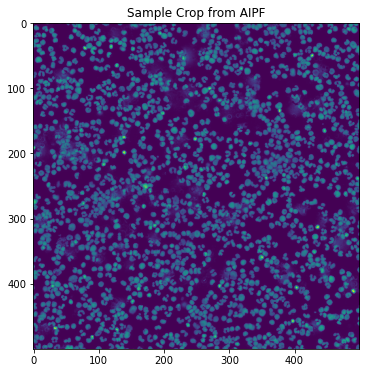

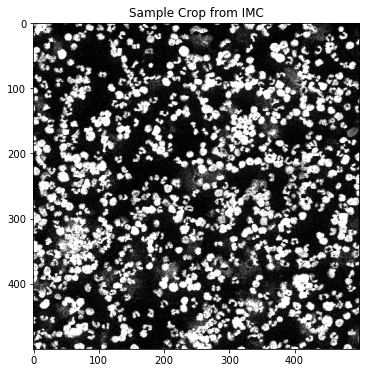

In [70]:
# visualize sample from both IMC and AIPF and determine a tile size (inital guess) and the stride (offset), here we chose between 2400 and 1200

plt.figure(figsize=(6,6))
plt.title('Sample Crop from AIPF')
plt.imshow(data_czi[7500:8000,7500:8000])

plt.figure(figsize=(6,6))
plt.title('Sample Crop from IMC')
plt.imshow(imc_img[0:500,0:500],cmap='gray') # the other 2 channels are opaque so we ignore them henceforth

In [5]:
# This function converts the image into overlapping tiles with size 1000x1000 and offset of 500

def window_nd(a, window, steps = None):
    ashp = np.array(a.shape)
    wshp = np.array(window).reshape(-1)
    if steps:
        stp = np.array(steps).reshape(-1)
    else:
        stp = np.ones_like(ashp)
    astr = np.array(a.strides)
    assert np.all(np.r_[ashp.size == wshp.size, wshp.size == stp.size, wshp <= ashp])
    shape = tuple((ashp - wshp) // stp + 1) + tuple(wshp)
    strides = tuple(astr * stp) + tuple(astr)
    as_strided = np.lib.stride_tricks.as_strided
    aview = as_strided(a, shape = shape, strides = strides)
    return aview

tiled_czi = window_nd(data_czi, (1000, 1000), (500, 500))
print(tiled_czi.shape)  # can be read as vertiacal tile id x horizontal tile id x height x width 

(23, 23, 1000, 1000)


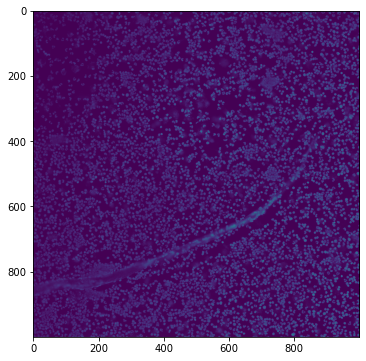

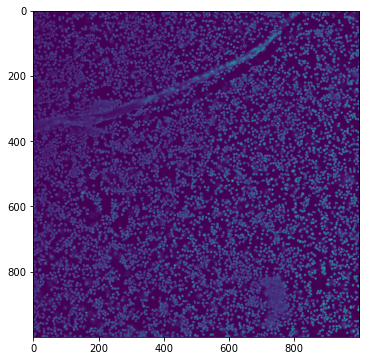

In [6]:
# visual check for tiled image with overlap

plt.figure(figsize=(6,6))
plt.imshow(tiled_czi[8,4,:,:])

plt.figure(figsize=(6,6))
plt.imshow(tiled_czi[9,4,:,:])

uint16 30763 140


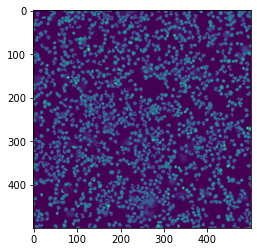

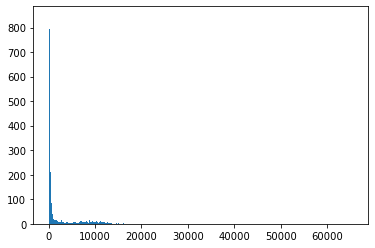

In [7]:
# Now we test some preprocessing operations for background noise correction

testczi_img = tiled_czi[10,12,:,:]
print(testczi_img.dtype, testczi_img.max(), testczi_img.min())

plt.figure()
plt.imshow(testczi_img[500:1000,500:1000])

plt.figure() # plotting here the histogram for the upcoming comparitive study in the next cell
plt.hist(testczi_img[500:1000,500:1000].ravel(),65536,[0,65536]);plt.show()

uint8 255 6


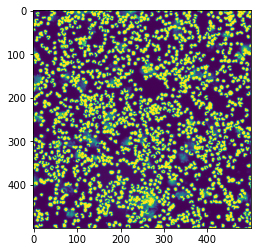

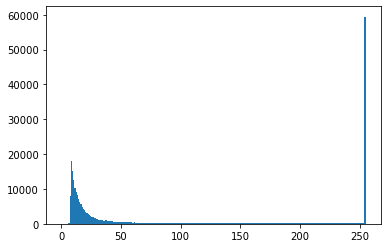

In [8]:
# contrast stretching (for better background seperability) and converting to uint8 (necessary evil for adaptive threshold mask)

alpha = 1/25 # Contrast control (1/50 is also okay)
beta = 0 # Brightness control (0-100)
enhancedTest_img = cv2.convertScaleAbs(testczi_img, alpha=alpha, beta=beta)
print(enhancedTest_img.dtype, enhancedTest_img.max(), enhancedTest_img.min())

plt.figure()
plt.imshow(enhancedTest_img[500:1000,500:1000])

plt.figure() # plotting here the histogram to better understand the effect of alpha
plt.hist(enhancedTest_img[500:1000,500:1000].ravel(),255,[0,255]);plt.show()

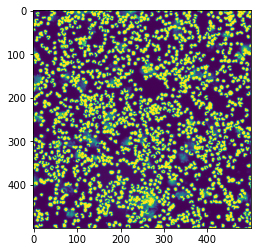

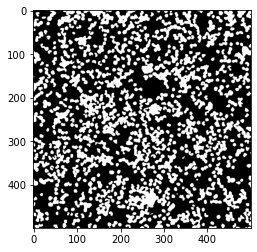

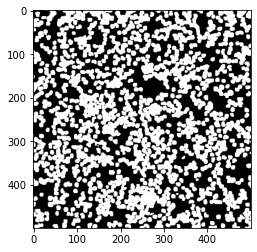

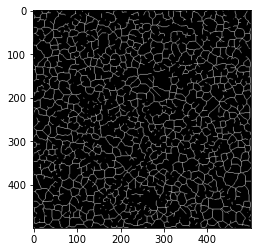

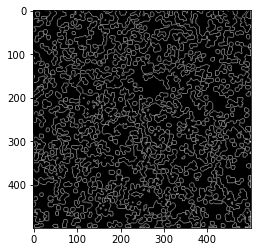

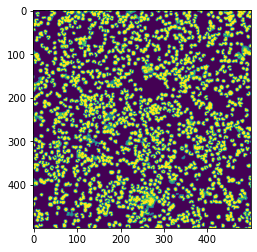

In [9]:
# Gausian Blur + Thresholding + dilation/or keep large cells only + skeletonize/perimeter
from skimage.morphology import skeletonize

img_blur = cv2.GaussianBlur(enhancedTest_img,(5,5),0)
_, th_otsu = cv2.threshold(img_blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
kerneld = np.ones((3,3), dtype=np.uint8)
dilated = cv2.dilate(th_otsu, kerneld) # increase mass of foreground
back_skel = skeletonize((255-dilated)/255)

contours, hierarchy = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cim = np.zeros_like(dilated)
cv2.drawContours(cim, contours, -1, 255, 1)

plt.figure(figsize=(4,4))
plt.imshow(enhancedTest_img[500:1000,500:1000])

plt.figure(figsize=(4,4))
plt.imshow((th_otsu)[500:1000,500:1000], cmap='gray')

plt.figure(figsize=(4,4))
plt.imshow((dilated)[500:1000,500:1000], cmap='gray')

plt.figure(figsize=(4,4))
plt.imshow((back_skel)[500:1000,500:1000], cmap='gray')

plt.figure(figsize=(4,4))
plt.imshow((cim)[500:1000,500:1000], cmap='gray')

plt.figure(figsize=(4,4))
plt.imshow((cv2.bitwise_and(enhancedTest_img, enhancedTest_img, mask=dilated))[500:1000,500:1000]) # instead of this calc skeleton

In [10]:
# functionizing the above preprocessing steps for runtime call

def preprocess_tile(img, alpha=1/25, beta=0, gray=0):
    enhanced_tile = cv2.convertScaleAbs(img, alpha=alpha, beta=beta) # for the other image just pass alpha=1
    img_blur = cv2.GaussianBlur(enhanced_tile,(5,5),0)
    _, th_otsu = cv2.threshold(img_blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kerneld = np.ones((3,3), dtype=np.uint8)
    dilated = cv2.dilate(th_otsu, kerneld) # increase mass of foreground
    
    
    # any of the below space will make a good candidate matching solution (Experiment!)
    #back_skel = skeletonize((dilated)/255) # skeleton of the background
    
    contours, hierarchy = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cim = np.zeros_like(dilated)
    cv2.drawContours(cim, contours, -1, 255, 1) # boundary of the cells
    
    # only proceed if contours exist
    if len(contours)>0:
        mom = cv2.moments(contours[0])
        Humoments = cv2.HuMoments(mom)
    else:
        Humoments = [100000] # just some high value
        
    if gray == 0:
        return cim, Humoments[0]
    else:
        return cv2.bitwise_and(enhanced_tile, enhanced_tile, mask=dilated), Humoments[0] # gray scale image with corrected background)

Moment AIPF is: [0.35416667]
Moment IMC is: [0.18048251]


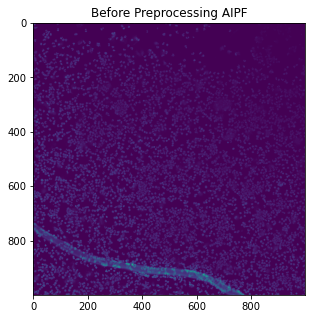

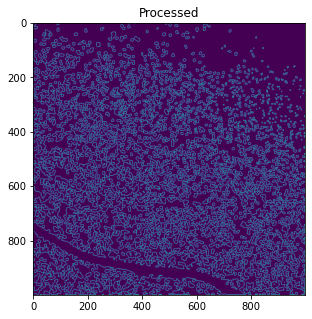

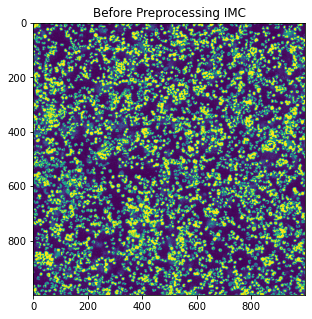

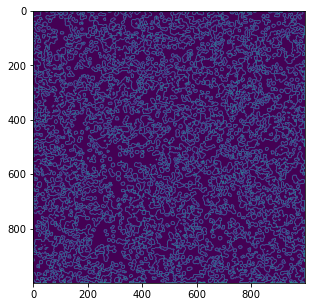

In [71]:
# illustration of the benefits of the above steps

plt.figure(figsize=(5,5))
plt.title('Before Preprocessing AIPF')
plt.imshow(tiled_czi[3,18,:,:])

plt.figure(figsize=(5,5))
tmp1, mom = preprocess_tile(tiled_czi[3,18,:,:])
plt.title('Processed')
plt.imshow(tmp1)
print('Moment AIPF is:', mom)

plt.figure(figsize=(5,5))
plt.title('Before Preprocessing IMC')
plt.imshow(imc_img)

plt.figure(figsize=(5,5))
tmp2, mom = preprocess_tile(imc_img, alpha=1)
print('Moment IMC is:', mom)
plt.imshow(tmp2)

# Now starts the real Image Registartion : 

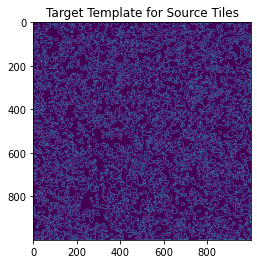

In [12]:
TH, TW, _, _ = tiled_czi.shape
template, _ = preprocess_tile(imc_img, alpha=1)
# template = cv2.rotate(template, cv2.ROTATE_180) # Don't want to use the hint!
match_score_array = np.zeros((TH,TW))

plt.figure()
plt.title('Target Template for Source Tiles')
plt.imshow(template)

Hu Moment [0.12869574]


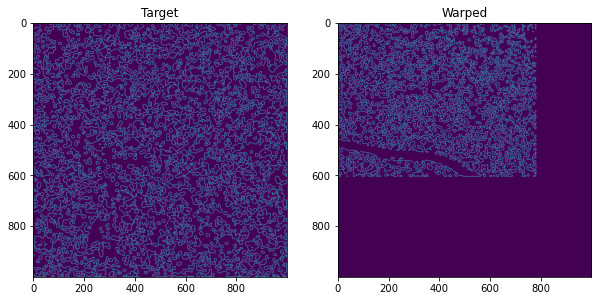

In [25]:
# register tmp1 and template
img, x = register_main(tmp1,template, infer=0)
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('Target')
plt.imshow(template)
plt.subplot(122)
plt.title('Warped')
plt.imshow(img)

print('Hu Moment', x['Similarity_Score'])

In [27]:
# Estimating similarity on tile

for i in range(TW):
    for j in range(TH):
        
        ij_tile, _ = preprocess_tile(tiled_czi[i,j,:,:], gray= 0)
        _, x = register_main(ij_tile, template, infer=0) # the call should be register_main(source, target)
        
        match_score_array[i,j] = x['Similarity_Score']
        print('Tile ID: {} {} has similarity score of {}'.format(i,j,match_score_array[i,j]))
        
        # free up memory
        del ij_tile, x
        gc.collect()

Tile ID: 0 0 has similarity score of 99999.81951748894
Tile ID: 0 1 has similarity score of 99999.81951748894
Tile ID: 0 2 has similarity score of 9.843121877567329
Tile ID: 0 3 has similarity score of 20.897224474814386
Tile ID: 0 4 has similarity score of 0.04173971129496426
Tile ID: 0 5 has similarity score of 0.04173971141865554
Tile ID: 0 6 has similarity score of 0.1804825110622674
Tile ID: 0 7 has similarity score of 0.16683341956636025
Tile ID: 0 8 has similarity score of 0.0035238157405441395
Tile ID: 0 9 has similarity score of 0.1804825110622674
Tile ID: 0 10 has similarity score of 0.1804825110622674
Tile ID: 0 11 has similarity score of 0.09729526671551039
Tile ID: 0 12 has similarity score of 0.056707879509070414
Tile ID: 0 13 has similarity score of 0.16683341956442202
Tile ID: 0 14 has similarity score of 0.09729526671551039
Tile ID: 0 15 has similarity score of 0.1804825110622674
Tile ID: 0 16 has similarity score of 0.05244692044912072
Tile ID: 0 17 has similarity sco

In [28]:
# in the match_score_array find array with the lowest non-zero value
minval = np.min(match_score_array[np.nonzero(match_score_array)])
i, j = np.where(match_score_array == minval)
print('The tile with indices i=',i,' and j=',j ,'had the lowest non zero similarity score = ',match_score_array[i,j])

The tile with indices i= [3]  and j= [7] had the lowest non zero similarity score =  [1.92421079e-12]


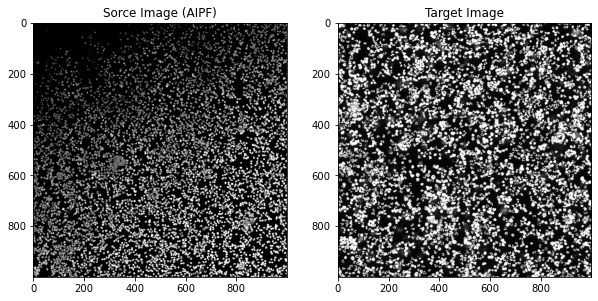

In [75]:
ij_tile, _ = preprocess_tile(tiled_czi[3,7,:,:], gray= 1)
template, _ = preprocess_tile(imc_img, alpha=1, gray= 1)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('Sorce Image (AIPF)')
plt.imshow(ij_tile,cmap='gray')
plt.subplot(122)
plt.title('Target Image')
plt.imshow(imc_img,cmap='gray')

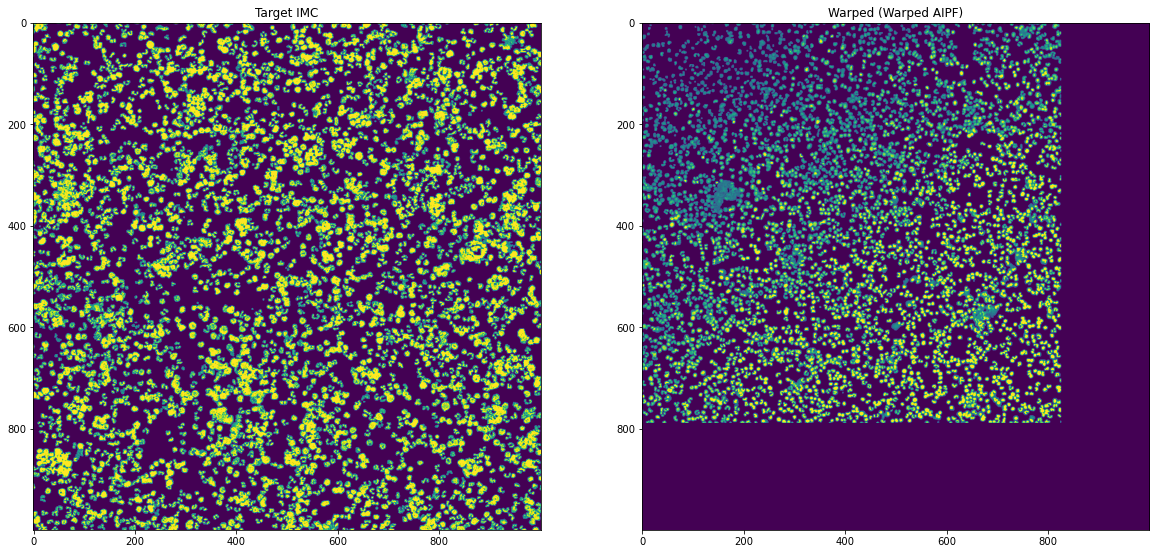

In [76]:
img, x = register_main(ij_tile, template, infer=1)
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.title('Target IMC')
plt.imshow(template)

plt.subplot(122)
plt.title('Warped (Warped AIPF)')
plt.imshow(img)
#plt.savefig('Result.png')

In [60]:
plt.imsave('Source_Tile.png',ij_tile)
plt.imsave('Target.png',template)
plt.imsave('Warped.png',img)

In [61]:
plt.imsave('SegmentIp.png',img,cmap='gray')